In [1]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx


n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

In [2]:
def build_cost_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliZ(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

cost_h = build_cost_h(n_qubits)
print(cost_h)

driver_h = build_driver_h(n_qubits)
print(driver_h)

def build_comm_h(n):
    coeffs = [2.0] * n
    ops = [qml.PauliY(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)
comm_h = build_comm_h(n_qubits)
print(comm_h)

-1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
-1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)
2.0 * Y(0) + 2.0 * Y(1) + 2.0 * Y(2) + 2.0 * Y(3)


In [ ]:
def falqon_layer(beta_k,cost_h,driver_h,delta_t):
    for c, op in zip(cost_h.coeffs, cost_h.ops):
        pauli_str = op.name[-1]
        qml.PauliRot(2 * c * delta_t, pauli_str, wires=op.wires)

    # Apply e^{-i β_k H_d Δt}
    for c, op in zip(driver_h.coeffs, driver_h.ops):
        pauli_str = op.name[-1]
        qml.PauliRot(2 * c * beta_k * delta_t, pauli_str, wires=op.wires)
    

In [4]:
def build_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta) 
        for w in dev.wires:
            qml.Hadamard(wires=w)
        for k in range(layers):
            falqon_layer(beta[k], cost_h, driver_h, delta_t)

    return ansatz 


def expval_circuit(beta, measurement_h):
    ansatz = build_ansatz(cost_h, driver_h, delta_t) 
    ansatz(beta)  
    return qml.expval(measurement_h)

In [5]:
def main_function(n_qubits, n, beta_1, delta_t, dev):
    cost_h = build_cost_h(n_qubits)
    driver_h = build_driver_h(n_qubits)
    comm_h = build_comm_h(n_qubits)


    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

    beta = [beta_1]
    energies = []

    for i in range(n):
        #print(qml.draw(cost_fn)(beta, measurement_h=cost_h))
        next_beta = -1 *delta_t* cost_fn(beta, measurement_h=comm_h)
        beta.append(next_beta)
        energy = cost_fn(beta, measurement_h=cost_h)
        energies.append(energy)

    return beta, energies

In [6]:
n = 100
beta_1 = 0.0
delta_t = 0.03
dev = qml.device("default.qubit", wires=n_qubits)
res_beta,res_energies = main_function(n_qubits, n, beta_1, delta_t, dev) 

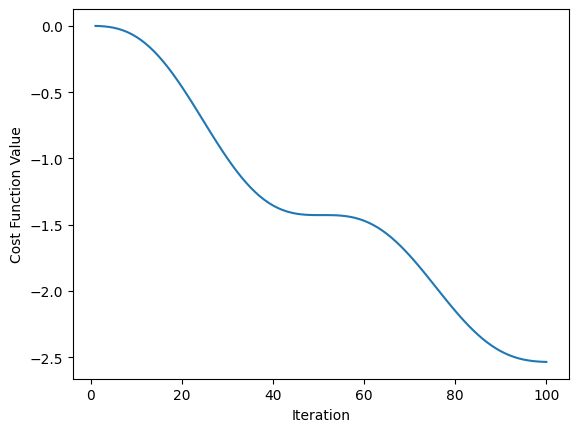

In [7]:
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()